# CC5215: Privacidad de Datos

## Laboratorio 7

Integrantes: (trabajé solo porque no pude conseguir un compañero de equipo)

- Nombre: Diego Espinoza

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

barbie_ratings = pd.read_csv('https://users.dcc.uchile.cl/~darquez/barbie_ratings.csv')

# YOU MAY USE THIS VARIABLES LATER
ratings = barbie_ratings['rating']
weights = barbie_ratings['weight']

## Introduction

In this lab we will work with a dataset of user ratings for the Barbie movie. In particular, we will try out different methods of making a weighted average of the ratings private.

In [ ]:
barbie_ratings.head()

,rating,weight
0,4,2
1,10,1
2,5,4
3,6,2
4,5,2


The dataset `barbie_ratings` has two columns: (1) `rating` which correspond to a rating given by a particular viewer, between 1 and 10; and (2) `weight` which corresponds to the importance of the given rating, between 1 and 4, based on previous data about the user (usefulness of other ratings, peer-voting, etc).

**IMPORTANT: Through this lab, it is not necessary that you manually clip the data to the aforementioned bounds. The data is already compliant with the bounds.**

In [2]:
## You may use this variables later:

# Upper bound for ratings
u = 10

# Upper bound for weights
wu = 4

## Question 1 (4 points)

The weighted average formula is defined as:

$$
\frac{\sum_{i=1}^n w_i * x_i}{\sum_{i=1}^n w_i}
$$

Where $w_i$ and $x_i$ in the ratings dataset corresponds to the the weight and rating of viewer $i$ respectively.
(Notice that when all the weights $w_i$ are $1$, the weighted average is equivalent to the regular average)

**Write a function that calculates the weighted average of a dataset**:

13629

In [8]:
def weighted_avg(data, weights):
    """
        Parameters:
            data (pd.Series): The data to average
            weights (pd.Series): The weights to calculate the average
        Returns:
            The `weights`-weighted average of `data`
    """
    numerador = (data*weights).sum()
    denominador = weights.sum()
    promedio = numerador / denominador 
    return promedio

weighted_avg(ratings, weights)

5.484507042253521

## Question 2 (6 points)

Write a differentially private version of `weighted_avg`, using global sensitivity.

In [12]:
import numpy as np
import pandas as pd

def laplace_noise(scale):
    return np.random.laplace(loc=0.0, scale=scale)

def gs_weighted_avg(data, weights, data_ub, weight_ub, epsilon):
    """
        Parameters:
            data (pd.Series): The data to average
            weights (pd.Series): The weights to calculate the average
            data_ub (int): Upper bound of the data values
            weight_ub (int): Upper bound of the weights
            epsilon (float): Privacy budget (must be > 0)
        Returns:
           Differentially private weighted average using global sensitivity
    """
    if epsilon <= 0:
        raise ValueError("Epsilon must be > 0 for differential privacy")

    data_clipped = data.clip(upper=data_ub)
    weights_clipped = weights.clip(upper=weight_ub)

    numerador = (data_clipped * weights_clipped).sum()
    denominador = weights_clipped.sum()

    #si cambiamos data solo un registro, la sensibilidad dice que
    #el numerador cambiará en exactamente uno multiplicado por
    #el peso (porque en el numerador se multiplican). 
    sens_numerador = data_ub * weight_ub
    #mientras que la sensibilidad del denominador no cambia sustancialmente (a lo más 
    # en el upper bound del peso).
    sens_denominador = weight_ub

    #dividimos el presupuesto entre el cálculo del numerador y del denominador
    epsilon_n = epsilon / 2
    epsilon_d = epsilon / 2

    numerador_ruidoso = numerador + laplace_noise(sens_numerador / epsilon_n)
    denominador_ruidoso = denominador + laplace_noise(sens_denominador / epsilon_d)

    return numerador_ruidoso / denominador_ruidoso


gs_weighted_avg(ratings, weights, u, wu, 0.1)

4.92946307776455

**Explain why your implementation is `epsilon`-DP**.

YOUR ANSWER

Cada una de las dos sumas tiene ruido calibrado para cumplir 
$\varepsilon_n$-DP y $\varepsilon_d$-DP respectivamente.

Como ambas partes de la función (es decir, el numerador como el denominador) operan sobre el mismo conjunto de datos original, podemos aplicar composición secuencial:
$$
f(D) = \frac{f_1(D) + \text{Lap}(\Delta_1 / \varepsilon_n)}{f_2(D) + \text{Lap}(\Delta_2 / \varepsilon_d)} \Rightarrow \text{es } (\varepsilon_n + \varepsilon_d)\text{-DP}
$$
pero como dividimos el presupuesto $\epsilon$ equitativamente entre $\varepsilon_n$ y $\varepsilon_d$, podemos decir que la función ´gs_weighted_avg´ es $(\varepsilon_n + \varepsilon_d)\text{-DP}$ o $(\varepsilon)\text{-DP}$


## Question 3 (6 points)

Calculate the local sensitivity of the weighted average.


YOUR ANSWER:

(Complete the following)

Given
$$
f(x, w) = \frac{\sum_{i=1}^n w_i * x_i}{\sum_{i=1}^n w_i}
$$

If we add a row:

$$
\begin{align}
|f(x, w) - f(x', w')| &= |   \frac{\sum_{i=1}^n w_i * x_i}{\sum_{i=1}^n w_i} -          \frac{\sum_{i=1}^{n+1} w_i * x_i}{\sum_{i=1}^{n+1} w_i}  | \\

                      &\leq  | \frac{\sum_{i=1}^n w_i * x_i}{\sum_{i=1}^{n+1} w_i} -          \frac{\sum_{i=1}^{n+1} w_i * x_i}{\sum_{i=1}^{n+1} w_i}|\\
                      &= |\frac{\sum_{i=1}^n w_i * x_i - \sum_{i=1}^{n+1} w_i * x_i}{\sum_{i=1}^{n+1} w_i}|\\
                      &= |\frac{w_{n+1}*x_{n+1}}{\sum_{i=1}^{n+1} w_i}|\\
                      &= |\frac{w_{n+1}*x_{n+1}}{\sum_{i=1}^n w_i + w_{n+1}}|\\
                      &= |\frac{w_{n+1}*x_{n+1}}{\text{suma}(w) + w_{n+1}}|\\
                      &\leq |\frac{4*10}{\text{suma}(w) + 4}|\\
                      &= |\frac{40}{\text{suma}(w) + 4}|
\end{align}
$$
Por lo tanto, podemos ver que la sensibilidad de dicha función depende de la suma de todos los ´weights´ (de la base de datos original, es decir, de aquella que aún no tiene ningún registro nuevo añadido), del peso y rating del nuevo registro $w_{n+1}$ y $x_{n+1}$, respectivamente. En general, es de esperar que dicha sensibilidad no sea muy grande si la ponderación del rating de cada persona es baja en relación a la suma de todos los pesos. Como el peso va entre 1 y 4 y el rating entre 1 y 10, podemos incluso ir más allá en la demostración. Por lo tanto, dicha función no es diferencialmente privada, porque si el analista sabe la sensibilidad local del dataset, puede inferir cosas de él (en el caso de la sensibilidad local).

## Question 4 (9 points)

As we saw in class, even though local sensitivity gives us a better upper bound than global sensitivity, we cannot directly use it with the mechanisms we have seen (e.g. laplace).

We will implement the Propose-Test-Release method for calculating a private weighted average of `barbie_ratings`. In order to do that, follow the next steps:

1. Implement a function to compute the *Maximum Local Sensitivity* at distance k:

In [ ]:
def ls_at_distance(target_ub, weight_ub, W, k):
    """
        Parameters:
            target_ub (int): Upper bound of the target values
            weight_ub (int): Upper bound of the weights
            W (int): Total sum of weights in the original dataset
            k (int): Number of steps away (number of changes)
        Returns:
            Local sensitivity at distance k
    """
    #el máximo peso añadido será k veces el peso máixmo:
    maximo_peso_añadido = k * weight_ub
    #como ya demostramos en la parte anterior,
    #el promedio máximo posible si agregamos k valores máximos será:
    cambio_superior = (target_ub * maximo_peso_añadido) / (W.sum() + maximo_peso_añadido)
    #el promedio mínimo posible si agregamos k valores mínimos será 0, porque
    #el mínimo de los pesos es cero, y por ende el promedio sería 0, así como 
    #el denominador:
    cambio_inferior = 0

    #y asumiendo promedio actual entre 0 y target_ub, evaluamos máximas diferencias
    delta_superior = abs(target_ub - cambio_superior)
    delta_inferior = abs(0 - cambio_inferior)

    return max(delta_superior, delta_inferior)


2. Implement a function to find the minimum number of steps to achieve a local sensitivity of at least $b$:

*Hint: Start by trying with $k=0$, and increment $k$ until the threshold of $b$ is achieved*

In [ ]:
def dist_to_high_ls(target_ub, weight_ub, W, b):
    """
        Parameters:
            target_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            W (int): The sum of the weights of the origin dataframe
            b (float): The proposed bound on local sensitivity
        Returns:
            The minimum number of steps to achieve a local sensitivity of at least `b`
    """
    #como dice el hint, primero inicializamos k como cero para ir incrementandolo
    #hasta que alcanzamos el valor b.
    k = 0
    while True:
        ls = ls_at_distance(target_ub, weight_ub, W, k)
        if ls >= b:
            return k
        k += 1

3. Implement the PTR version of weighted average:

In [ ]:
def ptr_weighted_avg(data, weights, data_ub, weight_ub, b, epsilon, delta):
    """
        Parameters:
            data    (pd.Series): The data to average, in this case, the ratings
            weights (pd.Series): The weights to calculate the average
            data_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            b (float): The proposed bound on local sensitivity
            epsilon, delta: The level of privacy
        Returns:
            The private weighted average using PTR
    """
    data_clipped = data.clip(upper=data_ub)
    k = dist_to_high_ls(data_ub, weight_ub, denominador, b)


    weights_clipped = weights.clip(upper=weight_ub)

    numerador = (data_clipped * weights_clipped).sum()
    denominador = weights_clipped.sum()
    avg = numerador / denominador


    beta = epsilon / (2 * np.log(2 / delta))
    smooth_sens = b * np.exp(-beta * k)
    noise = laplace_noise(scale=smooth_sens / epsilon)

    return avg + noise

In [23]:
ptr_weighted_avg(ratings, weights, u, wu, 0.02, 1.0, 10e-6)

5.464530557116332

## Question 5 (4 points)

The following code plots the relative errors (against the real answer) of global sensitivity and PTR:

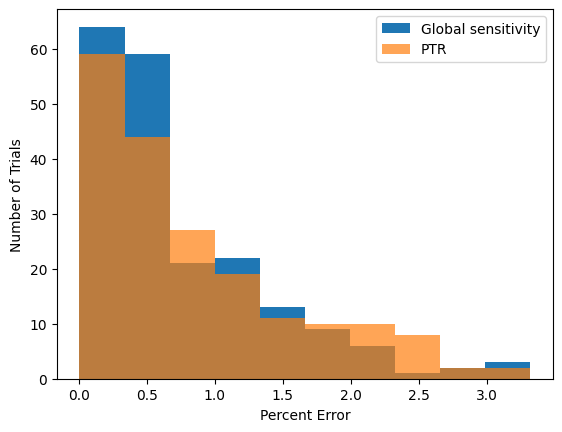

In [19]:
epsilon = 1.0
delta = 10e-6
b = 0.05

gs_errors = []
ptr_errors = []

real_avg = weighted_avg(ratings, weights)

for i in range(200):
    ptr_result = ptr_weighted_avg(ratings, weights, u, wu, b, epsilon, delta)

    gs_result = gs_weighted_avg(ratings, weights, u, wu, epsilon)
    gs_errors.append(pct_error(real_avg, gs_result))

    if ptr_result is None:
        continue

    ptr_errors.append(pct_error(real_avg, ptr_result))

_, bins, _ = plt.hist(gs_errors, label='Global sensitivity');
plt.hist(ptr_errors, alpha=.7, label='PTR', bins=bins);
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

1. Compare the accuracies of both methods. Which one is better? Explain how the plot helps justifying your analysis.
2. What can you say about the parameter $b$, in terms of the usability of the PTR method? How does this aspect compare to the global sensitivity method?

YOUR ANSWER HERE

## Question 6 (3 points)

Now, we will implement the weighted average using the Smooth Sensitivity framework.

First, implement `smooth_ls_at_distance`, which calculates the local sensitivity at distance $k$, smoothed out by an exponential factor of $e^{-\beta k}$:

In [ ]:
def smooth_ls_at_distance(data_ub, weight_ub, W, k, beta):
    """
        Parameters:
            data_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            W (int): The sum of the weights of the origin dataframe
            k (int): The number of steps away from the origin dataframe
            beta (float): The smooth factor
        Returns:
            The smoothed local sensitivity at distance k
    """
    raise NotImplementedError()

## Question 7 (2 points)

1. What does the following graph shows?
2. What information can we infer from this plot to help us implement a weighted average using smooth sensitivity?

In [ ]:
beta = 0.05

r = [smooth_ls_at_distance(u, wu, weights.sum(), k, beta) for k in range(0, 200)]

plt.plot(r);
plt.xlabel('Value of k')
plt.ylabel('Smoothed-out Local Sensitivity');

## Question 8 (6 points)

Implement the query using Smooth Sensitivity:

In [ ]:
def ss_weighted_avg(data, weights, data_ub, weight_ub, epsilon, delta):
    """
        Parameters:
            data    (pd.Series): The data to average
            weights (pd.Series): The weights to calculate the average
            data_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            epsilon, delta: The level of privacy
        Returns:
            The private weighted average using Smooth Sensitivity
    """
    raise NotImplementedError()

ss_weighted_avg(ratings, weights, u, wu, epsilon, delta)

## Question 9 (4 points)

The following code plots the relative errors (against the real answer) of global sensitivity and Smooth Sensitivity:

In [ ]:
gs_results  = [
    pct_error(weighted_avg(ratings, weights),
    gs_weighted_avg(ratings, weights, u, wu, epsilon)) for i in range(100)]
ptr_results = [
    pct_error(weighted_avg(ratings, weights),
    ss_weighted_avg(ratings, weights, u, wu, epsilon, delta)) for i in range(100)]

_, bins, _ = plt.hist(gs_results, label='Global sensitivity');
plt.hist(ptr_results, alpha=.7, label='Smooth sensitivity', bins=bins);
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

1. Compare the accuracies of both methods. Explain how the plot helps justifying your analysis.
2. What disadvantage has this method when comparing it with the global sensitivity approach?

## Question 10 (6 points)

Let us define a function that receives $k$ results, computed from **disjoint** sets of data, and calculates the clipped (by $l$ and $u$) average between them as follows:

$$
g_{l,u}(x) = \frac{\sum^k_{i=1} \mathsf{clip}(x_i, l, u)}{k}
$$

where $x$ is a vector that represent the average of each disjoint set of data.

**Calculate the global sensitivity of $g_{l,u}$.**

*Hint: Use the fact that the computations x_i are disjoint*

Complete:

$$
\begin{align*}
|g_{l,u}(x) - g_{l,u}(x')| &= \dots \\
                           &= \dots \\
                           &\leq \dots
\end{align*}
$$

## Question 11 (6 points)

Implement the Sample & Aggregate framework for weighted averages, using $g$ as your aggregation function.

*Hint: Use the function `np.array_split` to divide the dataframe in $k$ chunks.*

In [ ]:
def sa_weighted_avg(data, weights, k, l, u, epsilon):
    """
        Parameters:
            data    (pd.Series): The data to average
            weights (pd.Series): The weights to calculate the average
            k (int): The number of chunks
            l, u (int): The clipping parameters for dividing the partial averages
            epsilon (float): The privacy budget
        Returns:
            The private weighted average using Sample & Aggregate
    """
    raise NotImplementedError()

sa_weighted_avg(ratings, weights, 200, 2, 8, epsilon)

## Question 12 (4 points)

The following code plots the relative errors (against the real answer) of global sensitivity and Smooth Sensitivity:

In [ ]:
gs_results  = [
    pct_error(weighted_avg(ratings, weights),
    gs_weighted_avg(ratings, weights, u, wu, epsilon)) for i in range(100)]
ptr_results = [
    pct_error(weighted_avg(ratings, weights),
    sa_weighted_avg(ratings, weights, 200, 2, 8, epsilon)) for i in range(100)]

_, bins, _ = plt.hist(gs_results, label='Global sensitivity');
plt.hist(ptr_results, alpha=.7, label='Sam. & Agg.', bins=bins);
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

1. Compare the accuracies of both methods. Explain how the plot helps justifying your analysis.
2. We used bounds of $(2,8)$ as clipping parameters for the intermediate averages. Do you think those are reasonable bounds? Why?

YOUR ANSWER